# Poisson with Neumann conditions

Here, we'll demonstrate a solution of Laplace's equation,
with Neumann boundary conditions on a surface. Similar to the
Dirichlet problem in A Dirichlet Poisson problem, we will solve the
problem with one Neumann condition external to the surface,
and another Neumann value internal to the surface.

Our underlying problem is still

$$\nabla^2\varphi^+ = 0,\qquad \nabla^2\varphi^- = 0$$

where $+$ denotes the exterior and $-$ the interior of the surface. (We will
consider a circle of radius 1.) The boundary conditions on this surface are

$$\mathbf{n}\cdot\nabla\varphi^+ = v^+_n, \qquad \mathbf{n}\cdot\nabla\varphi^- = v^-_n$$

In other words, we seek to set the value on the exterior normal derivative to $v_n$
of the local normal vector on the surface, while the interior should have zero normal
derivative.

Discretizing this problem by the usual techniques, we seek to solve

$$\begin{bmatrix} L & D_s \\ G_s & R_n^T R_n \end{bmatrix} \begin{pmatrix} f \\ -[\phi] \end{pmatrix} = \begin{pmatrix} R [v_n] \\ \overline{v}_n \end{pmatrix}$$

where $\overline{v}_n = (v^+_n + v^-_n)/2$ and $[v_n] = v^+_n - v^-_n$. The resulting
$[\phi]$ is $f^+-f^-$.

As with the Dirichlet problem, this saddle-point problem can be solved by block-LU decomposition. First solve

$$L f^{*} = R [v_n]$$

for $f^*$. Then solve

$$-S [\phi] = \overline{v}_n - G_s f^{*}$$

for $[\phi]$, where $S = R_n^T R_n - G_s L^{-1} D_s = -C_s L^{-1}C_s^T$, and finally, compute

$$f = f^{*} + L^{-1}D_s [\phi]$$

It should be remembered that, for any scalar potential field, there is
a corresponding streamfunction $\psi$ that generates the same flow. We
can get that field, as well, with only a little bit more effort:

$$S [\psi] = C_s f^{*}$$

and then solve

$$L s = C_s^T [\phi] - \hat{C}_s^T [\psi]$$.

for the streamfunction $s$.

In [1]:
using ImmersedLayers
using Plots
using LinearAlgebra
using UnPack

## Set up the extra cache and solve function
The problem type takes the usual basic form

In [2]:
@ilmproblem NeumannPoisson scalar

The extra cache holds additional intermediate data, as well as
the Schur complement. We don't bother creating a filtering matrix here.

In [3]:
struct NeumannPoissonCache{SMT,DVT,VNT,FT,ST} <: AbstractExtraILMCache
   S :: SMT
   dvn :: DVT
   vn :: VNT
   fstar :: FT
   sstar :: ST
end

The function `prob_cache`, as before, constructs the operators and extra
cache data structures

In [4]:
function ImmersedLayers.prob_cache(prob::NeumannPoissonProblem,base_cache::BasicILMCache)
    S = create_CLinvCT(base_cache)
    dvn = zeros_surface(base_cache)
    vn = zeros_surface(base_cache)
    fstar = zeros_grid(base_cache)
    sstar = zeros_gridcurl(base_cache)
    NeumannPoissonCache(S,dvn,vn,fstar,sstar)
end
nothing #hide

And finally, here's the steps we outlined above, used to
extend the `solve` function

In [5]:
function ImmersedLayers.solve(prob::NeumannPoissonProblem,sys::ILMSystem)
    @unpack extra_cache, base_cache, bc, phys_params = sys
    @unpack S, dvn, vn, fstar, sstar = extra_cache

    fill!(fstar,0.0)
    fill!(sstar,0.0)

    f = zeros_grid(base_cache)
    s = zeros_gridcurl(base_cache)
    df = zeros_surface(base_cache)
    ds = zeros_surface(base_cache)

    # Get the precribed jump and average of the surface normal derivatives
    prescribed_surface_jump!(dvn,sys)
    prescribed_surface_average!(vn,sys)

    # Find the potential
    regularize!(fstar,dvn,base_cache)
    inverse_laplacian!(fstar,base_cache)

    surface_grad!(df,fstar,base_cache)
    df .= vn - df
    df .= -(S\df);

    surface_divergence!(f,df,base_cache)
    inverse_laplacian!(f,base_cache)
    f .+= fstar

    # Find the streamfunction
    surface_curl!(sstar,df,base_cache)

    surface_grad_cross!(ds,fstar,base_cache)
    ds .= S\ds

    surface_curl_cross!(s,ds,base_cache)
    s .-= sstar
    s .*= -1.0

    inverse_laplacian!(s,base_cache)

    return f, df, s, ds
end
nothing #hide

## Solve the problem
Here, we will demonstrate the solution on a circular shape of radius 1,
with $v_n^+ = n_x$ and $v_n^- = 0$. This is actually the set of conditions
used to compute the unit scalar potential field (and, as we will see, the added mass) in potential flow.

Set up the grid

In [6]:
Δx = 0.01
Lx = 4.0
xlim = (-Lx/2,Lx/2)
ylim = (-Lx/2,Lx/2)
g = PhysicalGrid(xlim,ylim,Δx)
Δs = 1.4*cellsize(g)
body = Circle(1.0,Δs);

Set the boundary condition functions

In [7]:
function get_vnplus(base_cache,phys_params)
    nrm = normals(base_cache)
    vnplus = zeros_surface(base_cache)
    vnplus .= nrm.u
    return vnplus
end
get_vnminus(base_cache,phys_params) = zeros_surface(base_cache)

bcdict = Dict("exterior"=>get_vnplus,"interior"=>get_vnminus)

Dict{String, Function} with 2 entries:
  "interior" => get_vnminus
  "exterior" => get_vnplus

Create the system

In [8]:
prob = NeumannPoissonProblem(g,body,scaling=GridScaling,bc=bcdict)
sys = construct_system(prob)
nothing #hide

Solve it

In [9]:
solve(prob,sys) #hide
@time f, df, s, ds = solve(prob,sys);

  0.055716 seconds (2.12 k allocations: 15.793 MiB, 10.25% compilation time)


and plot the field

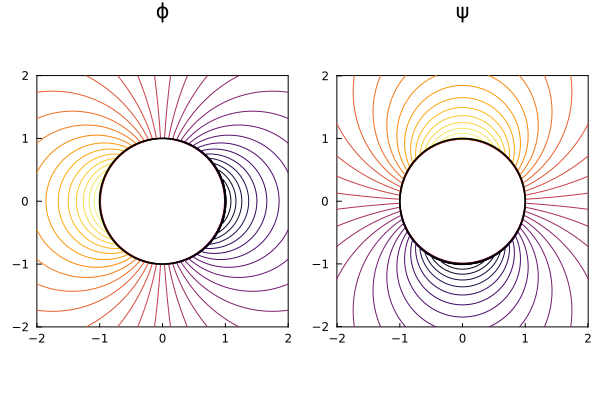

In [10]:
plot(plot(f,sys,layers=true,levels=30,title="ϕ"),
plot(s,sys,layers=true,levels=30,title="ψ"))

and the Lagrange multiplier field, $[\phi]$, on the surface

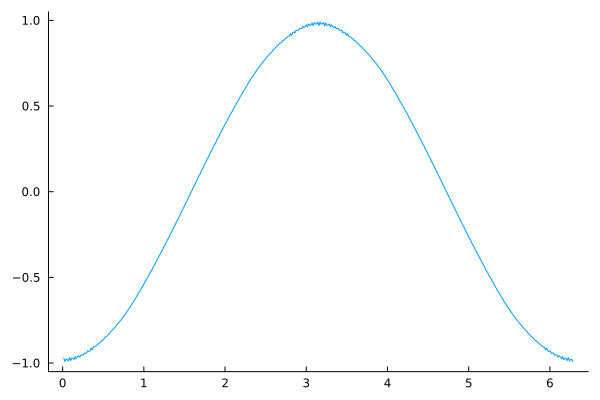

In [11]:
plot(df,sys)

If, instead, we set the inner boundary condition to $n_x$ and the
outer to zero, then we get the flow *inside* of a translating circle.
All we need to do is re-define the boundary functions

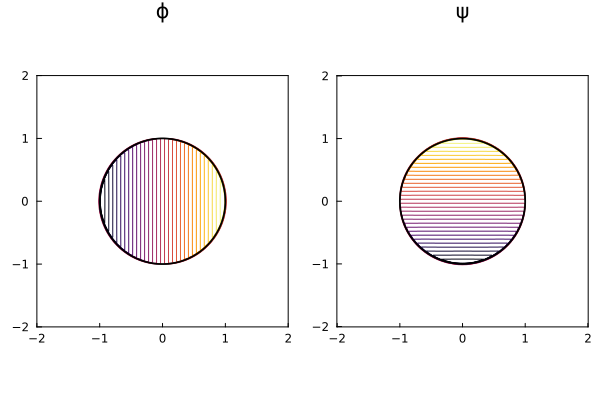

In [12]:
function get_vnplus(base_cache,phys_params)
    vnplus = zeros_surface(base_cache)
    return vnplus
end
function get_vnminus(base_cache,phys_params)
    nrm = normals(base_cache)
    vnminus = zeros_surface(base_cache)
    vnminus .= nrm.u
    return vnminus
end

f, df, s, ds = solve(prob,sys);
plot(plot(f,sys,layers=true,levels=30,title="ϕ"),
plot(s,sys,layers=true,levels=30,title="ψ"))

## Multiple bodies
The cache and solve function we created above can be applied for
any body or set of bodies. Let's apply it here to a circle of radius 0.25 inside of a
square of half-side length 2, where our goal is to find the effect of the enclosing square
on the motion of the circle. As such, we will set the Neumann conditions
both internal to and external to the square to be 0, but for the exterior of the
circle, we set it to $n_x$.

In [13]:
bl = BodyList();
push!(bl,Square(1.0,Δs))
push!(bl,Circle(0.25,Δs))
nothing #hide

We don't actually have to transform these shapes, but it is
illustrative to show how we would move them.

In [14]:
t1 = MotionTransform([0.0,0.0],0.0)
t2 = MotionTransform([0.0,0.0],0.0)
tl = MotionTransformList([t1,t2])
update_body!(bl,tl)
nothing #hide

Set the boundary conditions. We set only the exterior Neumann value
of body 2 (the circle). This gives us an opportunity to demonstrate the
 `copyto!` function, which is useful for setting only the part of
 the overall surface data associated with a certain body.

In [15]:
function get_vnplus(base_cache,phys_params)
    nrm = normals(base_cache)
    vnplus = zeros_surface(base_cache)
    copyto!(vnplus,nrm.u,base_cache,2)
    return vnplus
end
function get_vnminus(base_cache,phys_params)
    vnminus = zeros_surface(base_cache)
    return vnminus
end
bcdict = Dict("exterior"=>get_vnplus,"interior"=>get_vnminus)

Dict{String, Function} with 2 entries:
  "interior" => get_vnminus
  "exterior" => get_vnplus

Create the problem and system

In [16]:
prob = NeumannPoissonProblem(g,bl,scaling=GridScaling,bc=bcdict)
sys = construct_system(prob)
nothing #hide

Solve it and plot

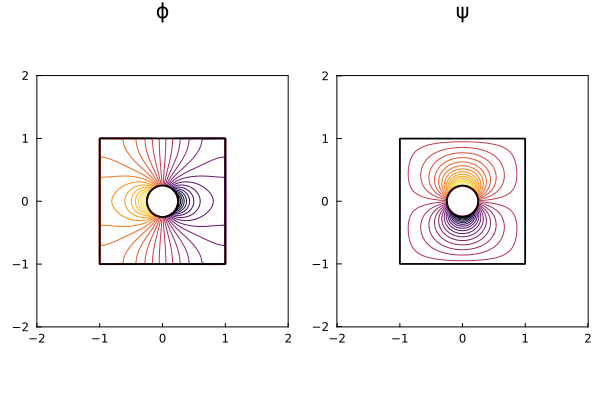

In [17]:
f, df, s, ds  = solve(prob,sys)
plot(plot(f,sys,layers=true,levels=30,title="ϕ"),
plot(s,sys,layers=true,levels=30,title="ψ"))

Now, let's compute the added mass components of the circle associated
with this motion. We are approximating

$$M = -\int_{C_2} f^+ \mathbf{n}\mathrm{d}s$$

where $C_2$ is shape 2 (the circle), and $f^+$ is simply $[\phi]$ on body 2.

In [18]:
nrm = normals(sys)
M = -integrate(df∘nrm,sys,2)

2-element Vector{Float64}:
  0.22649277527914002
 -4.407177849660021e-10

As one would expect, the circle has added mass in the $x$ direction
associated with moving in that direction.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*